In [4]:
import os
import time

import cv2
import scipy.io
import numpy as np
import pandas as pd
from scipy.io import loadmat
from skimage.io import imread
import matplotlib.pyplot as plt

from typing import Tuple, Dict, List, Union

In [2]:
def draw_bounding_boxes_grid(mat_file: str, image_dir: str, grid_size: Tuple[int, int] = (3, 3)) -> None:
    """
    Reads a .mat file containing bounding box coordinates, extracts the data for random images, and displays them
    in a grid with bounding boxes drawn.

    Parameters:
    mat_file (str): Path to the .mat file containing bounding box data.
    image_dir (str): Directory containing the images.
    grid_size (Tuple[int, int]): Dimensions of the grid (rows, columns).

    Returns:
    None

    Notes:
    - The .mat file is expected to contain a structure with fields: 'id', 'imageName', 'faceBox'.
    - Bounding boxes should be provided as top-left (x1, y1) and bottom-right (x2, y2) pixel coordinates.
    - Random images will be selected for display.

    Example:
    draw_bounding_boxes_grid("fga_face_detection_training.mat", "./training_images", grid_size=(4, 4))
    """

    # Load the .mat file
    try:
        data = scipy.io.loadmat(mat_file)
    except Exception as e:
        raise ValueError(f"Error reading .mat file: {e}")

    # Extract the structure
    key = list(data.keys())[-1]  # Assuming the last key contains the structure
    dataset = data[key]

    # Validate structure fields
    if not all(field in dataset.dtype.names for field in ['id', 'imageName', 'faceBox']):
        raise ValueError("The .mat file does not contain the required fields: 'id', 'imageName', 'faceBox'.")

    # Extract image names and bounding boxes
    image_names = dataset['imageName'].squeeze()
    bboxes = dataset['faceBox'].squeeze()

    # Normalize image names to avoid discrepancies (e.g., strip spaces, handle encoding)
    image_names = [image_name[0].strip() if isinstance(image_name[0], str) else image_name[0].decode('utf-8').strip() for image_name in image_names]

    # Randomly select images for the grid
    total_images = len(image_names)
    num_images = grid_size[0] * grid_size[1]
    selected_indices = np.random.choice(total_images, size=min(num_images, total_images), replace=False)

    # Prepare the plot
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
    axes = axes.ravel()

    for i, idx in enumerate(selected_indices):
        image_name = image_names[idx]  # Extract normalized image name

        # Construct the path to the image
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            print(f"Image {image_name} not found in {image_dir}. Skipping.")
            continue

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image {image_name}. Skipping.")
            continue

        # Extract bounding boxes for the current image
        image_bboxes = bboxes[idx]
        if image_bboxes.size > 0:
            for bbox in image_bboxes:
                x1, y1, x2, y2 = map(int, bbox)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Convert BGR to RGB for plotting
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image in the grid
        axes[i].imshow(image)
        axes[i].set_title(image_name)
        axes[i].axis("off")

    # Hide any unused subplots
    for j in range(len(selected_indices), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

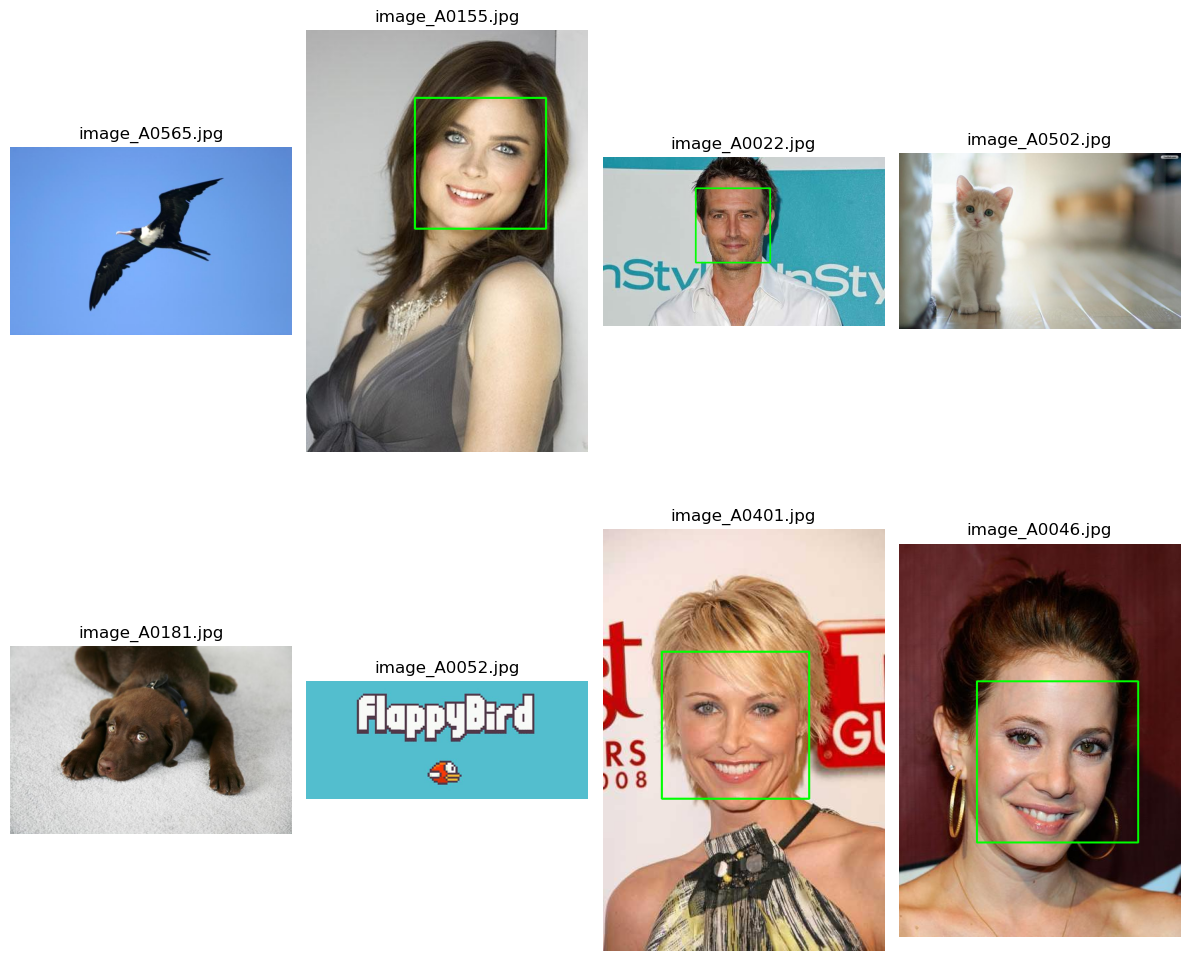

In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Construct the path to the correct directory
mat_file_path = os.path.join(parent_dir, "labs", "lab_1", "agc_challenge1_materials", "fga_face_detection_training.mat")
image_dir_path = os.path.join(parent_dir, "labs", "lab_1", "agc_challenge1_materials", "training")

# print("MAT file path:", mat_file_path)
# print("Image directory path:", image_dir_path)


# Example usage:
draw_bounding_boxes_grid(mat_file_path,image_dir_path, grid_size=(2, 4))


# Introduction to Haar Cascade for Face Detection

Haar Cascade, also known as the Viola-Jones object detection framework, is one of the pioneering algorithms for real-time object detection, particularly face detection. Developed by Paul Viola and Michael Jones in 2001, it remains a foundational method in computer vision due to its efficiency and simplicity.

---

## How Haar Cascade Works

Haar Cascade is a machine learning-based approach that uses a cascade of classifiers to detect objects. The process can be divided into the following steps:

### 1. **Feature Selection**
   - The algorithm uses Haar-like features to represent the object.
   - Haar-like features are rectangular patterns, similar to convolution kernels, that compute the difference in intensities between adjacent regions of an image.
   - Common features include edge, line, and four-rectangle features.

### 2. **Integral Image**
   - To speed up feature computation, an intermediate representation of the image, called the integral image, is used.
   - The integral image allows quick calculation of the sum of pixel values within any rectangular region of the image.

### 3. **AdaBoost Training**
   - A large number of Haar-like features are initially considered, but most are irrelevant.
   - AdaBoost, a machine learning algorithm, is used to select the most relevant features and create a strong classifier from weak ones.

### 4. **Cascade of Classifiers**
   - The algorithm uses a series of classifiers arranged in a cascade.
   - Each stage of the cascade filters out non-face regions, significantly reducing the number of candidate regions for subsequent stages.
   - Only regions that pass all stages of the cascade are classified as faces.

---

## Advantages of Haar Cascade
- **Real-time Detection**: The cascade structure allows quick elimination of non-face regions, making it efficient for real-time applications.
- **Pre-trained Models**: OpenCV provides pre-trained HaarCascade classifiers for various objects, including faces, eyes, and smiles.

---

## Limitations of Haar Cascade
- **Sensitivity to Lighting Conditions**: The algorithm may fail under varying lighting conditions.
- **Limited Generalization**: Haar-like features work well for frontal faces but struggle with rotated or partially occluded faces.
- **Outdated for Complex Tasks**: With advancements in deep learning, Haar Cascade has been largely replaced by CNN-based models for face detection.

---

## Practical Implementation
In this lab, we will use OpenCV's pre-trained HaarCascade classifier (`haarcascade_frontalface_default.xml`) to detect faces in images. This implementation will demonstrate the fundamental concepts of the Haar Cascade algorithm and its application to real-world scenarios.

---

### References
- Viola, Paul, and Michael Jones. "Rapid object detection using a boosted cascade of simple features." Proceedings of the 2001 IEEE Computer Society Conference on Computer Vision and Pattern Recognition.
- OpenCV Documentation: [Haar Cascade Classifier](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html)



In [4]:
def detect_faces_with_haar(image_dir: str, cascade_file: str, grid_size: Tuple[int, int] = (3, 3)) -> None:
    """
    Detects faces in images using HaarCascade (Viola-Jones) algorithm, saves bounding box coordinates, and plots
    random detections in a grid.

    Parameters:
    image_dir (str): Directory containing the images.
    cascade_file (str): Path to the HaarCascade XML file.
    grid_size (Tuple[int, int]): Dimensions of the grid (rows, columns).

    Returns:
    None

    Example:
    detect_faces_with_haar("./training_images", "haarcascade_frontalface_default.xml", grid_size=(3, 3))
    """
    # TODO: Implement the function
    pass

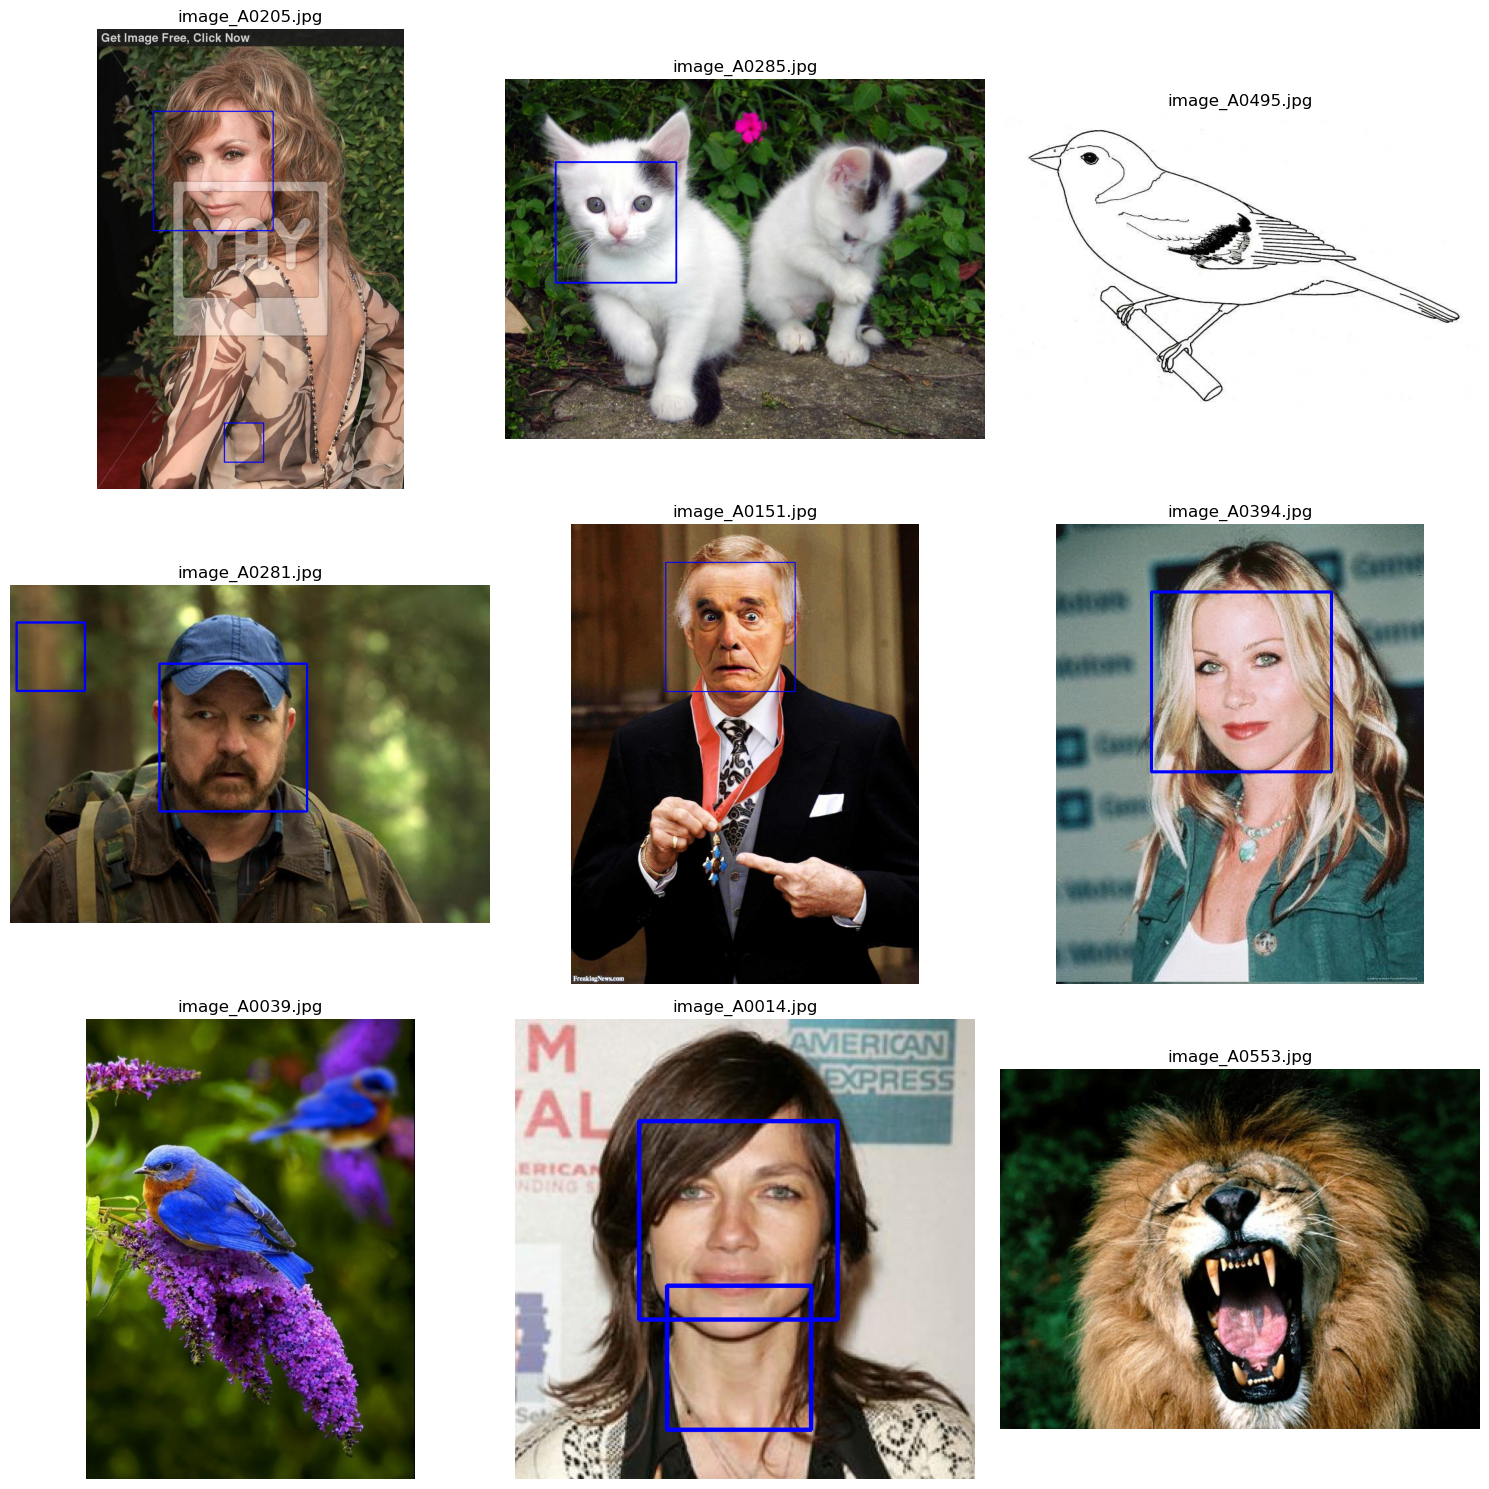

In [ ]:
bboxes = detect_faces_with_haar(image_dir_path, "haarcascade_frontalface_default.xml", grid_size=(3, 3))

# Understanding Haar Cascade Parameters in `detectMultiScale`

The `detectMultiScale` function is the core of face detection in OpenCV's Haar Cascade. This function scans the image at multiple scales and identifies regions that match the features of a face. Below is an explanation of its parameters:

---

## Parameters of `detectMultiScale`

### 1. **`gray`**
   - This is the grayscale version of the input image.
   - **Why Grayscale?** Haar Cascade operates faster and more effectively on a single-channel image because it doesn't rely on color information.

---

### 2. **`scaleFactor`**
   - **Definition**: This parameter specifies how much the image size is reduced at each scale.
   - **Default Value**: `1.1` (reduces the size by 10% each time).
   - **Explanation**:
     - The algorithm scans the image multiple times, scaling it down at each step.
     - A smaller value (e.g., `1.05`) means more scales and thus finer detection but slower performance.
     - A larger value (e.g., `1.2`) speeds up detection but risks missing smaller faces.
   - **Tip**: For datasets with faces of varying sizes, experiment with `scaleFactor` values between `1.05` and `1.2`.

   ![GIF of image being scaled](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*pOZ9-EqqqZAn0B3uUOOrRw.gif)

---

### 3. **`minNeighbors`**
   - **Definition**: Specifies how many neighbor rectangles each candidate rectangle must have to be considered a face.
   - **Default Value**: `5`.
   - **Explanation**:
     - A higher value (e.g., `6-8`) reduces false positives but may miss smaller or partially occluded faces.
     - A lower value (e.g., `3`) increases sensitivity but may introduce more false positives.
   - **Tip**: Adjust this parameter based on your dataset. If you observe many false positives, increase `minNeighbors`.

   ![GIF showing overlapping bounding boxes](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZpG0rAuwgdBd-y_0HKyrNg.jpeg)

---

### 4. **`minSize`**
   - **Definition**: Specifies the minimum size of a face to be detected (width, height).
   - **Default Value**: `(30, 30)`.
   - **Explanation**:
     - Faces smaller than this size will be ignored.
     - Useful for ignoring noise in the background or irrelevant objects.
   - **Tip**: Adjust `minSize` according to the resolution of your dataset. For high-resolution images, increase this value to reduce false positives.

   ![GIF showing smaller faces being filtered](https://wider-challenge.org/img/2019/portfolio/face.png)

---

## Tips for Improving Face Detection Performance

### 1. **Preprocess the Images**
   - **Why it helps**: Normalizing lighting improves contrast and highlights facial features, making them easier to detect.
   - **How to do it**: Apply histogram equalization to the grayscale images:
     ```python
     gray = cv2.equalizeHist(gray)
     ```
   - **Impact**: Makes features like eyes and noses more distinct, especially in poorly lit images.

   ![GIF showing histogram equalization](https://www.researchgate.net/publication/4308761/figure/fig4/AS:394633780711428@1471099433225/a-Original-Image-b-Image-after-histogram-equalization-c-Histogram-of-image-in.png)

---

### 2. **Combine Frontal and Profile Detectors**
   - **Why it helps**: Some faces may be oriented sideways, which a frontal detector may miss.
   - **How to do it**:
     - Apply a frontal detector first, then a profile detector.
     - Use Non-Maximum Suppression (NMS) to merge overlapping bounding boxes:
       ```python
       all_faces = np.vstack((frontal_faces, profile_faces))
       final_faces = non_max_suppression(all_faces)
       ```
   - **Tip**: Rotate images 90° and 270° to detect inverted profiles.

   ![GIF showing combination of detectors](https://miro.medium.com/v2/resize:fit:1400/1*o_BzZqMSV1lOtSSNgqeKkw.png)

---

### 3. **Filter Detections**
   - **Why it helps**: Eliminates detections that don't match the expected size or shape of faces.
   - **How to do it**:
     ```python
     faces = [face for face in faces if 0.8 < face[2] / face[3] < 1.2]
     ```
   - **Impact**: Reduces false positives by filtering detections that are too wide or narrow.

---

### 4. **Augment the Dataset**
   - **Why it helps**: Data augmentation improves model robustness to different conditions.
   - **How to do it**:
     - Rotate, flip, or add noise to your images.
     - Example:
       ```python
       flipped_image = cv2.flip(image, 1)
       ```

   ![Face data augmentation](https://miro.medium.com/v2/resize:fit:1200/1*zcKMFwf_kiPZgY_Ulr2t1g.png)

---

### 5. **Analyze Dataset Characteristics**
   - **Why it helps**: Understanding the dataset's patterns ensures better parameter tuning.
   - **How to do it**:
     - **Resolution**: Check the average face size and adjust `minSize` accordingly:
       ```python
       face_sizes = [(bbox[2] - bbox[0], bbox[3] - bbox[1]) for bbox in ground_truth_bboxes]
       avg_face_size = np.mean(face_sizes, axis=0)
       print("Average face size:", avg_face_size)
       ```
     - **Lighting**: Compute and visualize intensity histograms to identify underexposed regions:
       ```python
       histogram = cv2.calcHist([gray], [0], None, [256], [0, 256])
       plt.plot(histogram)
       ```

   ![Dataset characteristics](https://datasciencedojo.com/wp-content/uploads/43.jpg)

---

### Summary
By fine-tuning the parameters of `detectMultiScale` and applying the tips mentioned above, you can significantly improve the accuracy and robustness of your face detection system, maximizing your chances of winning the challenge.



# Introduction to Histogram of Oriented Gradients (HOG) for Face Detection

Histogram of Oriented Gradients (HOG) is a powerful feature descriptor widely used in object detection, including face detection. It gained prominence for its ability to capture the structure of objects by analyzing gradients in an image. This method is often combined with a classifier, such as a Support Vector Machine (SVM), to perform face detection.

---

## How HOG Works

The HOG algorithm converts an image into a feature vector that encodes its structural information. Here's a step-by-step breakdown:

### 1. **Gradient Calculation**
   - **What happens**: The algorithm computes the gradient (change in intensity) at every pixel in the image.
   - **Why it matters**: Gradients highlight edges, corners, and textures, which are key features of faces.
   - **Implementation**: The gradients are calculated in both horizontal (x) and vertical (y) directions.

   ![GIF showing gradient calculation](https://miro.medium.com/v2/resize:fit:1184/format:webp/1*b3kV7VVWZOiMG6a76_APFg.png)

---

### 2. **Spatial Division into Cells**
   - **What happens**: The image is divided into small regions called cells (e.g., 8x8 pixels).
   - **Why it matters**: By analyzing small regions, HOG captures local features that are less affected by changes in lighting or scale.

   ![GIF of image divided into cells](https://miro.medium.com/v2/resize:fit:960/format:webp/1*Ka5onIOpjmRIOHViItFQjg.gif)

---

### 3. **Orientation Binning**
   - **What happens**: For each cell, the algorithm creates a histogram of gradient orientations (e.g., 0° to 180°).
   - **Why it matters**: The histogram encodes the dominant edges in the cell, making it invariant to small geometric or photometric transformations.
   - **Key step**: Gradients are weighted by their magnitude before being added to the histogram.

---

### 4. **Block Normalization**
   - **What happens**: To make the feature vector robust to changes in lighting, the histograms from neighboring cells are grouped into overlapping blocks (e.g., 16x16 pixels), and the gradients are normalized.
   - **Why it matters**: This step ensures that the algorithm is robust to lighting and contrast variations across the image.

---

### 5. **Feature Vector Creation**
   - **What happens**: The normalized histograms are concatenated into a single feature vector representing the entire image.
   - **Why it matters**: This feature vector serves as the input for a classifier, such as an SVM, to detect faces.

---

## Advantages of HOG
1. **Robust to Illumination Changes**: The block normalization step ensures consistency in varying lighting conditions.
2. **Rotation and Scale Invariance**: By analyzing gradients locally, the algorithm performs well across different face orientations and sizes.
3. **Lightweight and Fast**: HOG is computationally efficient, making it suitable for real-time applications.

---

## Limitations of HOG
1. **Sensitivity to Occlusion**: Faces partially covered by objects (e.g., hands, masks) are harder to detect.
2. **Less Effective for Non-Frontal Faces**: While HOG works well for frontal faces, its performance decreases for rotated or profile views.
3. **Rigid Framework**: Compared to deep learning-based detectors, HOG lacks the flexibility to learn complex features from data.

---

## HOG for Face Detection with dlib

In practice, the HOG method is often implemented using the **dlib library**, which combines HOG features with an SVM classifier for face detection.

### Key Parameters of dlib's HOG-based Detector
- **Upsample Factor**: Determines the number of times the image is resized to detect smaller faces.
  - **Default**: `1` (no upsampling).
  - **Tip**: Increase this value (e.g., `2` or `3`) to detect smaller faces but at the cost of slower performance.
- **Threshold**: Filters out weak detections by setting a minimum confidence level.

---

In [6]:
import dlib

def detect_faces_with_hog(image_dir: str, grid_size: Tuple[int, int] = (3, 3)) -> None:
    """
    Detects faces in random images using HOG-based face detection, and displays them in a grid with bounding boxes drawn.

    Parameters:
    image_dir (str): Directory containing the images.
    grid_size (Tuple[int, int]): Dimensions of the grid (rows, columns).

    Returns:
    None

    Example:
    detect_faces_with_hog("./training_images", grid_size=(4, 4))
    """
    # TODO: Implement the function
    pass

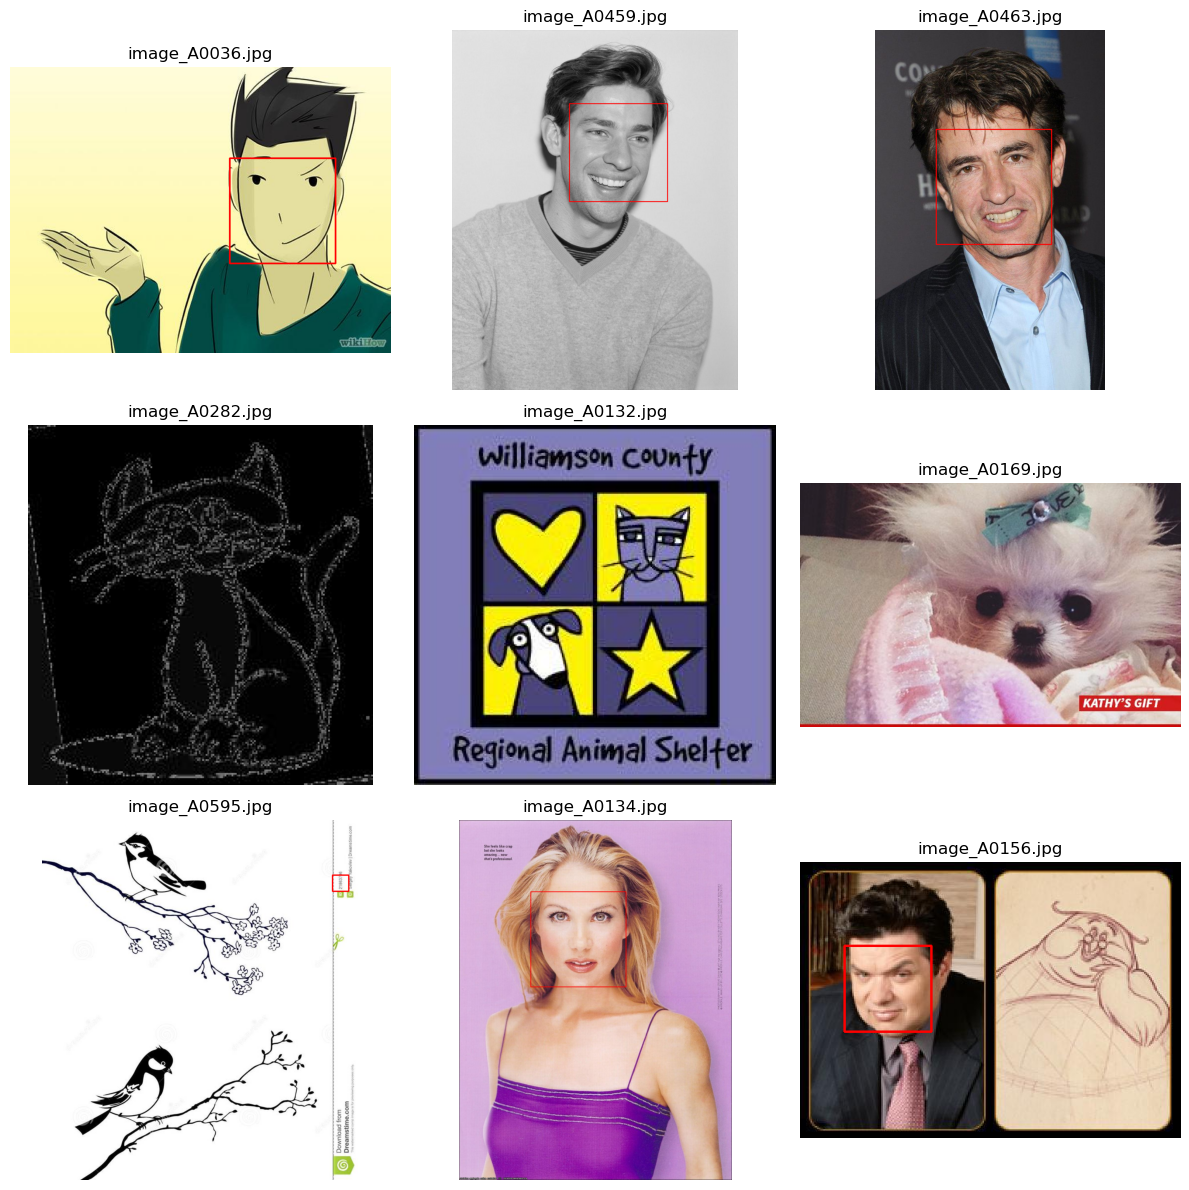

In [7]:
detect_faces_with_hog(image_dir_path, grid_size=(3, 3))

In [37]:
def compute_detection_scores(
    DetectionSTR: List[List[List[Union[int, float]]]],
    AGC_Challenge1_STR: pd.DataFrame,
    show_figures: bool = False
) -> float:
    """
    Compute face detection scores (F1-score) for detected bounding boxes against ground truth.

    Parameters:
    DetectionSTR (List[List[List[Union[int, float]]]]):
        Detection results for each image. Each entry is a list of bounding boxes `[x1, y1, x2, y2]`.
    AGC_Challenge1_STR (pd.DataFrame):
        Ground truth DataFrame with 'imageName' (image paths) and 'faceBox' (bounding boxes).
    show_figures (bool):
        If True, displays images with ground truth and detected bounding boxes.

    Returns:
    float: Average F1-score across all images.
    """
    all_f1_scores = []

    for idx, row in AGC_Challenge1_STR.iterrows():
        gt_boxes = row["faceBox"]
        det_boxes = DetectionSTR[idx]

        # Ensure valid array checks
        if len(gt_boxes) == 0 and len(det_boxes) == 0:
            all_f1_scores.append(1.0)  # Perfect score for empty ground truth and detection
            continue
        elif len(gt_boxes) == 0 or len(det_boxes) == 0:
            all_f1_scores.append(0.0)  # No match
            continue

        # Initialize IoU matrix
        iou_matrix = np.zeros((len(gt_boxes), len(det_boxes)))

        for i, gt in enumerate(gt_boxes):
            for j, det in enumerate(det_boxes):
                # Ensure bounding boxes are valid
                if gt[2] <= gt[0] or gt[3] <= gt[1] or det[2] <= det[0] or det[3] <= det[1]:
                    continue

                # Calculate IoU
                x1, y1 = max(gt[0], det[0]), max(gt[1], det[1])
                x2, y2 = min(gt[2], det[2]), min(gt[3], det[3])
                intersection = max(0, x2 - x1) * max(0, y2 - y1)
                union = (
                    (gt[2] - gt[0]) * (gt[3] - gt[1]) +
                    (det[2] - det[0]) * (det[3] - det[1]) -
                    intersection
                )
                iou_matrix[i, j] = intersection / union if union > 0 else 0

        # Match detections to ground truths
        matched = iou_matrix > 0.5  # Threshold for IoU
        true_positives = np.sum(matched.any(axis=1))
        false_positives = len(det_boxes) - true_positives
        false_negatives = len(gt_boxes) - true_positives

        # Calculate F1-score
        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        all_f1_scores.append(f1_score)

        # Optionally display results
        if show_figures:
            image = imread(row["imageName"])
            fig, ax = plt.subplots()
            ax.imshow(image)
            for box in gt_boxes:
                ax.add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='blue', fill=False))
            for box in det_boxes:
                ax.add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='green', fill=False))
            plt.title(f"F1-score: {f1_score:.2f}")
            plt.show()

    # Compute mean F1-score
    return np.mean(all_f1_scores)



In [38]:
def MyFaceDetectionFunction(A: np.ndarray, model: str = "haar") -> List[List[Union[int, float]]]:
    """
    Detects faces in an input image using the specified detection model (Haar Cascade or HOG).

    Parameters:
    A (np.ndarray):
        Input image (as a NumPy array) for face detection.
    model (str):
        The face detection model to use. Options are:
        - "haar": Haar Cascade-based face detection (default).
        - "hog": HOG-based face detection using dlib.

    Returns:
    List[List[Union[int, float]]]:
        A list of bounding boxes where each bounding box is represented as [x1, y1, x2, y2].
    """
    # TODO: Implement the function
    return []

In [ ]:
# Basic script for Face Detection Challenge
# --------------------------------------------------------------------
# AGC Challenge
# Universitat Pompeu Fabra

# Basic script for Face Detection Challenge
# --------------------------------------------------------------------
# AGC Challenge
# Universitat Pompeu Fabra

# Load challenge Training data
dir_challenge = "/path/to/challenge_materials/"
AGC_Challenge1_TRAINING = loadmat(dir_challenge + "fga_face_detection_training.mat")

AGC_Challenge1_TRAINING = np.squeeze(AGC_Challenge1_TRAINING["AGC_Challenge1_TRAINING"])
AGC_Challenge1_TRAINING = [
    [row.flat[0] if row.size == 1 else row for row in line]
    for line in AGC_Challenge1_TRAINING
]
columns = ["id", "imageName", "faceBox"]
AGC_Challenge1_TRAINING = pd.DataFrame(AGC_Challenge1_TRAINING, columns=columns)

# Set the path to the input images
imgPath = "/path/to/training_images/"
AGC_Challenge1_TRAINING["imageName"] = imgPath + AGC_Challenge1_TRAINING["imageName"].astype(str)

# Initialize results structure
DetectionSTR = []

# Initialize timer accumulator
total_time = 0

for idx, im in enumerate(AGC_Challenge1_TRAINING["imageName"]):
    print(im)
    A = imread(im)
    try:
        ti = time.time()
        # Timer on
        ###############################################################
        # Run face detection function with the desired model
        det_faces = MyFaceDetectionFunction(A, model="haar")  # Replace "haar" with "hog" for HOG detection
        ###############################################################
        tt = time.time() - ti
        total_time += tt
    except Exception as e:
        print(f"Error processing image {im}: {e}")
        det_faces = []

    DetectionSTR.append(det_faces)

# Compute F1-score
FD_score = compute_detection_scores(DetectionSTR, AGC_Challenge1_TRAINING, show_figures=False)

# Display results
_, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(
    "F1-score: %.2f, Total time: %2d m %.2f s" % (100 * FD_score, int(minutes), seconds)
)

# F1-score: 90.83, Total time:  2 m 42.54 s (HOG)
# F1-score: 73.38, Total time:  0 m 15.38 s (Haar Cascade)
